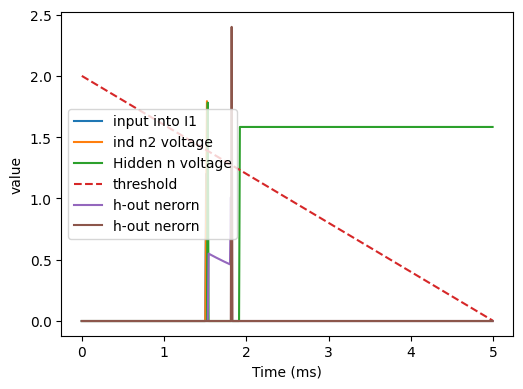

Recorded spikes: [{0: [1.51], 1: [1.51]}, {0: [1.52], 1: [1.9100000000000001], 2: [1.9100000000000001], 3: [1.7100000000000002]}, {0: [1.53], 1: [1.7200000000000002]}, {0: [1.81], 1: [1.81], 2: [1.81], 3: [1.81]}, {0: [1.8200000000000003], 1: [1.8200000000000003]}]
Group 0 spikes:
  Neuron 0: [1.51]
  Neuron 1: [1.51]

Group 1 spikes:
  Neuron 0: [1.52]
  Neuron 1: [1.9100000000000001]
  Neuron 2: [1.9100000000000001]
  Neuron 3: [1.7100000000000002]

Group 2 spikes:
  Neuron 0: [1.53]
  Neuron 1: [1.7200000000000002]

Group 3 spikes:
  Neuron 0: [1.81]
  Neuron 1: [1.81]
  Neuron 2: [1.81]
  Neuron 3: [1.81]

Group 4 spikes:
  Neuron 0: [1.8200000000000003]
  Neuron 1: [1.8200000000000003]



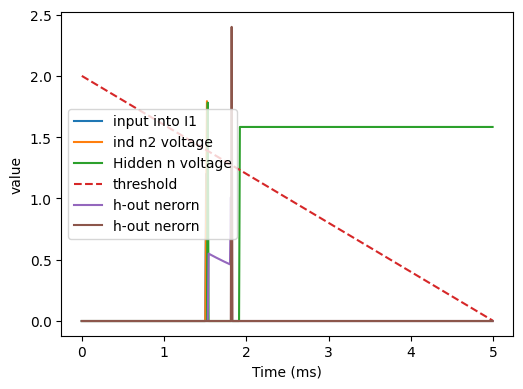

1 [1.5, 1.9, 1.9, 1.7]
2 [1.5, 1.9, 1.9, 1.7]

news - input 1 1.33 1.52
news - input 2 1.33 1.9100000000000001
dis 1.52 1.9100000000000001
None
[0.2, 0.2]


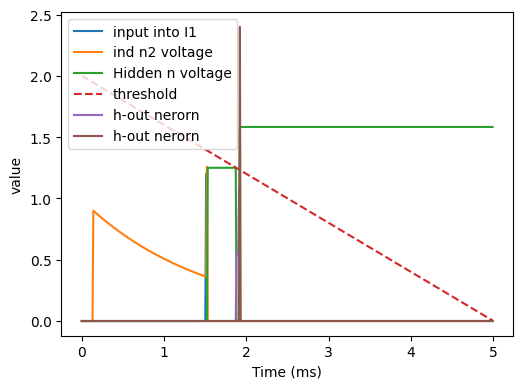

Recorded spikes: [{0: [1.51], 1: [1.51]}, {0: [1.52], 1: [1.52], 2: [1.9100000000000001], 3: [1.7100000000000002]}, {0: [1.87], 1: [1.7200000000000002]}, {0: [1.9100000000000001], 1: [1.9100000000000001], 2: [1.9100000000000001], 3: [1.9100000000000001]}, {0: [1.9200000000000002], 1: [1.9200000000000002]}]
Group 0 spikes:
  Neuron 0: [1.51]
  Neuron 1: [1.51]

Group 1 spikes:
  Neuron 0: [1.52]
  Neuron 1: [1.52]
  Neuron 2: [1.9100000000000001]
  Neuron 3: [1.7100000000000002]

Group 2 spikes:
  Neuron 0: [1.87]
  Neuron 1: [1.7200000000000002]

Group 3 spikes:
  Neuron 0: [1.9100000000000001]
  Neuron 1: [1.9100000000000001]
  Neuron 2: [1.9100000000000001]
  Neuron 3: [1.9100000000000001]

Group 4 spikes:
  Neuron 0: [1.9200000000000002]
  Neuron 1: [1.9200000000000002]



[{0: [1.51], 1: [1.51]},
 {0: [1.52], 1: [1.52], 2: [1.9100000000000001], 3: [1.7100000000000002]},
 {0: [1.87], 1: [1.7200000000000002]},
 {0: [1.9100000000000001],
  1: [1.9100000000000001],
  2: [1.9100000000000001],
  3: [1.9100000000000001]},
 {0: [1.9200000000000002], 1: [1.9200000000000002]}]

In [39]:
# going to just edit with layer 1


from brian2 import *
import numpy as np
import logging, warnings

start_scope()

defaultclock.dt = 0.01*ms  

#prefs.codegen.target = 'cython'
set_device('runtime')
warnings.filterwarnings('ignore', category=RuntimeWarning)  # check error later
np.seterr(over='ignore', under='ignore')
logging.getLogger('brian2').setLevel(logging.ERROR)

decay_rate = 1.5*ms

def run_Ymir(inputs, y, z,taus1, taus2):

    x = len(inputs)
    xy_ind = x*y
    yz_ind = y*z
 

    if len(taus1) != xy_ind:
        print("not the right size for taus1 buddy")
        raise ValueError(f"Length of taus1 wrong .")

    input_neurons = NeuronGroup(x,'''
    dv/dt = -v/ decay_rate : volt                 
        ''',
    threshold='v > 1.0 * volt',
    reset='v = 0 * volt',
    method='exact')
    input_neurons.v = 0 * volt

    indices_input = []
    for i in range(0, x):
        indices_input.append(i)

    stim_input = SpikeGeneratorGroup(x, indices=indices_input, times= inputs * ms)

    syn_input = Synapses(stim_input, input_neurons[0:x], '''
    ''', on_pre='''
        v += 1.2 * volt
    ''')
    syn_input.connect(j='i') 

    ind_input_neurons = NeuronGroup(xy_ind,
    '''dv/dt = -v/ decay_rate : volt 
         
        ''',
    threshold='v > 1.0 * volt',
    reset='v = 0 * volt',
    method='exact')
    ind_input_neurons.v = 0 * volt

    input_range = []
    for i in range(0, x):
        for j in range(0, y):
            input_range.append(i)


    ind_input = Synapses(input_neurons[0:x], ind_input_neurons[0:xy_ind], '''
    ''', on_pre='''
        v += 0.9 * volt
    ''')
    ind_input.connect(i=input_range, j=[k for k in range(0, xy_ind)]) # look into what j is later


    stim_tau_hidden = SpikeGeneratorGroup(xy_ind, indices=[k for k in range(0, xy_ind)], times = taus1 * ms)

    syn_tau_hidden = Synapses(stim_tau_hidden, ind_input_neurons[0:xy_ind], '''
    ''', on_pre='''
        v += 0.9 * volt
    ''')
    syn_tau_hidden.connect(j='i')

    

    hidden_neurons = NeuronGroup(
    y,
    '''
    v : volt
    dVth/dt = -k : volt
    k : volt/second
    locked : integer
    ''',
    threshold='(v > Vth) and (locked == 0)',
    reset='''
    v = 0*volt
    locked = 1
    ''',
    method='euler'  # Euler is required to integrateso we can integrate the decay
    )

    hidden_neurons.v = 0*volt
    hidden_neurons.Vth = Threshold_starting*volt
    hidden_neurons.k = 400 *volt/second  # decay rate
    hidden_neurons.locked = 0



    output_range = []
    for i in range(0, x):
        for j in range(0, y):
            output_range.append(j)

    syn_ind_hidden = Synapses(ind_input_neurons[0:xy_ind], hidden_neurons[0:y], '''
    ''', on_pre='''
        v_post += v_pre
    ''')
 #v += 1.2 * volt
    syn_ind_hidden.connect(i=[k for k in range(0, xy_ind)], j=output_range)


    ind_hidden_neurons = NeuronGroup(yz_ind,
    '''dv/dt = -v/ decay_rate : volt 
        
        ''',
    threshold='v > 1.0 * volt',
    reset='v = 0 * volt',
    method='exact')
    ind_hidden_neurons.v = 0 * volt

    hidden_range = []
    for i in range(0, y):
        for j in range(0, z):
            hidden_range.append(i)


    syn_hidden_output = Synapses(hidden_neurons[0:y], ind_hidden_neurons[0:yz_ind], '''
    ''', on_pre='''
        v += 0.55 * volt
    ''')
    syn_hidden_output.connect(i=hidden_range, j=[k for k in range(0, yz_ind)])


    stim_tau_output = SpikeGeneratorGroup(yz_ind, indices=[k for k in range(0, yz_ind)], times = taus2 * ms)

    syn_tau_output = Synapses(stim_tau_output, ind_hidden_neurons[0:yz_ind], '''
    ''', on_pre='''
        v += 0.55 * volt
    ''')
    syn_tau_output.connect(j='i')

    output_neurons = NeuronGroup(z,
    '''dv/dt = -v/ decay_rate : volt 
        
        ''',
    threshold='v > 1.0 * volt',
    reset='v = 0 * volt',
    method='exact')
    output_neurons.v = 0 * volt

    output_out_range = []
    for i in range(0, y):
        for j in range(0, z):
            output_out_range.append(j)

    syn_output = Synapses(ind_hidden_neurons[0:yz_ind], output_neurons[0:z], '''
    ''', on_pre='''
        v += 1.2 * volt
    ''')

    syn_output.connect(i=[k for k in range(0, yz_ind)], j=output_out_range)

    

    mon = StateMonitor(input_neurons, 'v', record=True, dt=0.01*ms)
    M1 = StateMonitor(ind_input_neurons, 'v', record=True, dt=0.01*ms)

    M2 = StateMonitor(hidden_neurons, ['v', 'Vth'], record=True, dt=0.01*ms)

    M3 = StateMonitor(ind_hidden_neurons, 'v', record=True, dt=0.01*ms)
    M4 = StateMonitor(output_neurons, 'v', record=True, dt=0.01*ms)

    spikemon = SpikeMonitor(input_neurons)
    spikemon_1 = SpikeMonitor(ind_input_neurons)
    spikemon_2 = SpikeMonitor(hidden_neurons)
    spikemon_3 = SpikeMonitor(ind_hidden_neurons)
    spikemon_4 = SpikeMonitor(output_neurons)


    run(5*ms)

    plt.figure(figsize=(10,4))

    plt.subplot(1,2,1)
    plt.plot(mon.t/ms, mon.v[0], label='input into I1')
    #plt.plot(mon.t/ms, mon.v[1], label='input into I2')
    plt.plot(M1.t/ms, M1.v[0], label='ind n2 voltage')
    #plt.plot(M1.t/ms, M1.v[1], label='ind n2 voltage')
    plt.plot(M2.t/ms, M2.v[0], label='Hidden n voltage')
    #plt.plot(M2.t/ms, M2.v[1], label='output n voltage')
    plt.plot(M2.t/ms, M2.Vth[0], '--', label='threshold')
    plt.plot(M3.t/ms, M3.v[0], label='h-out nerorn')
    plt.plot(M4.t/ms, M4.v[0], label='h-out nerorn')

    #plt.plot(M_mid.t/ms, M_mid.theta[0], '--', label='theta (middle)')
    #plt.plot(M_out.t/ms, M_out.v[0], label='v (output)')
    plt.xlabel('Time (ms)')
    plt.ylabel('value')
    plt.legend()

    #plt.subplot(1,2,2)
    #plt.plot(spm_mid.t/ms, spm_mid.i, 'o', label='middle spikes')
    #plt.plot(spm_out.t/ms, spm_out.i + 1, 'o', label='output spikes')  # offset for display
    #plt.yticks([0, 1], ['middle', 'output'])
    #plt.xlabel('Time (ms)')
    #plt.legend()

    plt.tight_layout()
    plt.show()


    results = []
    results.append(spikemon.spike_trains())
    results.append(spikemon_1.spike_trains())
    results.append(spikemon_2.spike_trains())
    results.append(spikemon_3.spike_trains())
    results.append(spikemon_4.spike_trains())

    

    return results   # check the dictionalry apect of this as the odder might be changing so harder wirinign i-j such relationship

# funcition for training taus
def see_system_run():
    raw_results = run_Ymir(inputs, y, z, taus1, taus2)

    recorded_spikes = [
        {neuron_idx: (spike_times / ms).tolist()  # convert to float ms
        for neuron_idx, spike_times in group.items()}
        for group in raw_results
    ]

    print("Recorded spikes:", recorded_spikes)

    for i in range(len(recorded_spikes)):
        print(f"Group {i} spikes:")
        for neuron_idx, spike_times in recorded_spikes[i].items():
            print(f"  Neuron {neuron_idx}: {spike_times}")
        print()
    return recorded_spikes

def tau_shifer(spike, tau, i, strength, closer=True):
    global h_neurons_sumed_movements
    # i is equal to what syn we are on 0 and 2 are n0 and 1 & 3 --> n1
    delta = spike - tau
    j = int(i > 1)

    if closer:
        # Original behavior: bigger delta → bigger step toward spike
        step = delta * strength
        if tau + step < 0:
            h_neurons_sumed_movements[j] += 0.02
            return 0.02
        h_neurons_sumed_movements[j] += step
        return tau + step
    else:
        # Inverse scaling: bigger delta → smaller step
        if delta == 0:
            h_neurons_sumed_movements[j] += 0.02
            return tau + 0.02  # struck will always fire if - is in range? - make sure 0 is always out of range for possilbe inputs? 
        step = (strength / abs(delta)) * delta  # sign from delta
        if tau - step < 0:
            h_neurons_sumed_movements[j] += 0.02
            return 0.02
        h_neurons_sumed_movements[j] -= step
        return tau - step
        
def directions(output_spikes, desired):
     # just firinng for a single spike or not change change later
    mods = [-1] * len(desired)  # assuming we want to modify all neurons
    
    for i in range(len(desired)): 
        if desired[i] == True:    # if we wanted a spike
            if output_spikes[i] == []: # if no spike saw
                mods[i] = 2 
            else:                   # if spike saw
                mods[i] = 0
        else:
            if output_spikes[i] == []: # if we didnt want a spike and it didnt spike
                mods[i] = 3
            else:   # if we didnt want it to spike but it did
                mods[i] = 1
    return mods     

def train_taus_last_layer(inputs, y, z,taus1, taus2, strength, desired):

    # run it and gets data with current values
    raw_results = run_Ymir(inputs, y, z, taus1, taus2)

    recorded_spikes = [
        {neuron_idx: (spike_times / ms).tolist()  # convert to float ms
        for neuron_idx, spike_times in group.items()}
        for group in raw_results
    ]
     # here we have the data of all the spikes and taus and desired we send into to get new taus
    
    d = directions(recorded_spikes[2], desired)  # get the directions for the taus

    # basied on direction get proper assocaltion for each direction and strength for updating and send each though tau shifter
    move = False
    count = 0
    index = 0
    for i in range((len(taus2))):
        # if spike as well
            #if i % 2 == 0: # even index taus        # will need to change to extend to multi later
        if d[index] % 2 == 0:  # 0 and 2 here
            move = True
        else:
            move = False
        if recorded_spikes[2][count] != []:  # if we saw a spike
 
            new_tau = tau_shifer(recorded_spikes[2][count][0], taus2[i], i, strength, closer=move)
            #print("new tay and old tau: ", new_tau, taus2[i])
            taus2[i] = new_tau
    
        else: 
            #new_tau = tau_shifer(0, taus2[i], strength, closer=move)  # if no spike saw then just use 0
            print("condition of change on condition of hidden not having spike ")# DID YOU EVER GOT HEREEEE")
            #print("no spike saw so no update?" )#new tay and old tau: ", new_tau, taus2[i])
            #taus2[i] = new_tau

        if (i+1) % 2 == 0:
            count += 1
        if index == 0:
            index += 1
        elif index == 1:
            index = 0
    

    return #recorded_spikes[3]  # return the last layer spikes for now


def move_toward_target(value, target=0, max_jump=1.0, scale=0.1): # cause error when scale was 0.01 --? why it said negitive spike? 
    """
    Move 'value' toward 'target', proportional to its distance, but capped at 'max_jump'.

    Parameters:
        value (float): The current number.
        target (float): The number we are moving toward (default is 0).
        max_jump (float): Maximum allowed jump in one call.
        scale (float): Fraction of the distance to move each step.

    Returns:
        float: The updated number after moving toward target.
    """
    distance = target - value
    step = distance * scale

    # Limit the step to max_jump
    if step > max_jump:
        step = max_jump
    elif step < -max_jump:
        step = -max_jump

    return value + step


def first_layer_shifter(value_shift, neuron_number, recorded_spikes):
    print(2, taus1)
    current_spike_time = recorded_spikes[2][neuron_number][0]
    new_spike1 = current_spike_time - value_shift[0] # as tau movment is being sent so oposite of tau movment is ideal
    new_spike2 = current_spike_time - value_shift[1]
    input_spike_1 = recorded_spikes[1][0][0]
    input_spike_2 = recorded_spikes[1][1][0]
    print()
    print("news - input 1", new_spike1,  input_spike_1)
    print("news - input 2", new_spike2,  input_spike_2)
    dis1 = new_spike1 = input_spike_1
    dis2 = new_spike2 = input_spike_2

    print("dis", dis1, dis2)

    taus1[0] -= move_toward_target(dis1)
    taus1[1] -= move_toward_target(dis2)


    # if input_spike_1 < new_spike1:
    #     if input_spike_1 < taus1[0]:
    #         taus1[0] -= move_toward_target(dis1)
    #     else:
    #         taus1[0] += 0.05
    # else:
    #     taus1[0] -= 0.05
                                           # need instead to just move taus towards spikes(not just in whatever Direction we assume is best)
    # if input_spike_2 < new_spike2:       # with that need to have sharper increase of spiking as gets closer also prob add a grad of improvement as well as them
    #     if input_spike_2 < taus1[1]:
    #         taus1[1] -= 0.05
    #     else:
    #         taus1[1] += 0.05
    # else:
    #     taus1[1] -= 0.05
        
     

    # return taus1
    # get the value we are shifting by as a sum
    # collect each syn from the neuron # can just just 0 and 2 and 1 and 3 for now directly
    # get spike time
    # calc new ideal spike time
    # fidn the spikes before/after new ideal time 
    # move tau closer to for spikes before and further for spikes after ideal range
    # ^ can be basic + 0.02 or - 0.02 for now


    pass 
    
Threshold_starting = 2

inputs = [1.5, 1.5]
y = 2
z = 2
Threshold_starting = 2
h_neurons_sumed_movements = [0] * y 

taus1 = [1.5, 1.9, 1.9, 1.7] 
taus2 = [1.8, 1.8, 1.8, 1.8] 

# run_Ymir(inputs, y, z, taus1, taus2)

#train_taus_last_layer(inputs, taus1, .1, [True])

# example of 2x2x2 moveing of neuron to all types of T/F and so on

recorded_spikes = see_system_run() # make a run function and not just a system_run function
train_taus_last_layer(inputs, y, z, taus1, taus2, .1, [False, False])
print(1, taus1)
print(first_layer_shifter(h_neurons_sumed_movements, 0, recorded_spikes))
print(h_neurons_sumed_movements)
see_system_run()


In [38]:
move_toward_target(.5, scale=.9)

0.04999999999999999

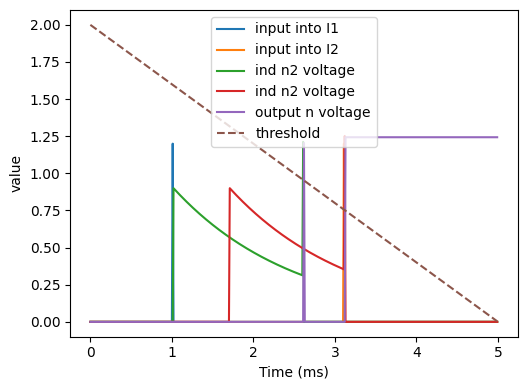

Recorded spikes: [{0: [1.01], 1: [3.1100000000000003]}, {0: [2.6100000000000003], 1: [3.12]}, {0: [2.62]}]
Group 0 spikes:
  Neuron 0: [1.01]
  Neuron 1: [3.1100000000000003]

Group 1 spikes:
  Neuron 0: [2.6100000000000003]
  Neuron 1: [3.12]

Group 2 spikes:
  Neuron 0: [2.62]

[0]
[2.649999999999998, 1.650000000000005]


In [64]:
# going to just edit with layer 1


from brian2 import *
import numpy as np
import logging, warnings

start_scope()

defaultclock.dt = 0.01*ms  

#prefs.codegen.target = 'cython'
set_device('runtime')
warnings.filterwarnings('ignore', category=RuntimeWarning)  # check error later
np.seterr(over='ignore', under='ignore')
logging.getLogger('brian2').setLevel(logging.ERROR)

decay_rate = 1.5*ms

def run_Ymir(inputs, y, taus1):

    x = len(inputs)
    xy_ind = x*y
 

    if len(taus1) != xy_ind:
        print("not the right size for taus1 buddy")
        raise ValueError(f"Length of taus1 wrong .")

    input_neurons = NeuronGroup(x,'''
    dv/dt = -v/ decay_rate : volt                 
        ''',
    threshold='v > 1.0 * volt',
    reset='v = 0 * volt',
    method='exact')
    input_neurons.v = 0 * volt

    indices_input = []
    for i in range(0, x):
        indices_input.append(i)

    stim_input = SpikeGeneratorGroup(x, indices=indices_input, times= inputs * ms)

    syn_input = Synapses(stim_input, input_neurons[0:x], '''
    ''', on_pre='''
        v += 1.2 * volt
    ''')
    syn_input.connect(j='i') 

    ind_input_neurons = NeuronGroup(xy_ind,
    '''dv/dt = -v/ decay_rate : volt 
         
        ''',
    threshold='v > 1.0 * volt',
    reset='v = 0 * volt',
    method='exact')
    ind_input_neurons.v = 0 * volt

    input_range = []
    for i in range(0, x):
        for j in range(0, y):
            input_range.append(i)


    ind_input = Synapses(input_neurons[0:x], ind_input_neurons[0:xy_ind], '''
    ''', on_pre='''
        v += 0.9 * volt
    ''')
    ind_input.connect(i=input_range, j=[k for k in range(0, xy_ind)]) # look into what j is later


    stim_tau_hidden = SpikeGeneratorGroup(xy_ind, indices=[k for k in range(0, xy_ind)], times = taus1 * ms)

    syn_tau_hidden = Synapses(stim_tau_hidden, ind_input_neurons[0:xy_ind], '''
    ''', on_pre='''
        v += 0.9 * volt
    ''')
    syn_tau_hidden.connect(j='i')

    

    hidden_neurons = NeuronGroup(
    y,
    '''
    v : volt
    dVth/dt = -k : volt
    k : volt/second
    locked : integer
    ''',
    threshold='(v > Vth) and (locked == 0)',
    reset='''
    v = 0*volt
    locked = 1
    ''',
    method='euler'  # Euler is required to integrateso we can integrate the decay
    )

    hidden_neurons.v = 0*volt
    hidden_neurons.Vth = Threshold_starting*volt
    hidden_neurons.k = 400 *volt/second  # decay rate
    hidden_neurons.locked = 0



    output_range = []
    for i in range(0, x):
        for j in range(0, y):
            output_range.append(j)

    syn_ind_hidden = Synapses(ind_input_neurons[0:xy_ind], hidden_neurons[0:y], '''
    ''', on_pre='''
        v_post += v_pre
    ''')
 #v += 1.2 * volt
    syn_ind_hidden.connect(i=[k for k in range(0, xy_ind)], j=output_range)



    mon = StateMonitor(input_neurons, 'v', record=True, dt=0.01*ms)
    M1 = StateMonitor(ind_input_neurons, 'v', record=True, dt=0.01*ms)
    M2 = StateMonitor(hidden_neurons, ['v', 'Vth'], record=True, dt=0.01*ms)


    spikemon = SpikeMonitor(input_neurons)
    spikemon_1 = SpikeMonitor(ind_input_neurons)
    spikemon_2 = SpikeMonitor(hidden_neurons)


    run(5*ms)

    plt.figure(figsize=(10,4))

    plt.subplot(1,2,1)
    plt.plot(mon.t/ms, mon.v[0], label='input into I1')
    plt.plot(mon.t/ms, mon.v[1], label='input into I2')
    plt.plot(M1.t/ms, M1.v[0], label='ind n2 voltage')
    plt.plot(M1.t/ms, M1.v[1], label='ind n2 voltage')
    plt.plot(M2.t/ms, M2.v[0], label='output n voltage')
    #plt.plot(M2.t/ms, M2.v[1], label='output n voltage')
    plt.plot(M2.t/ms, M2.Vth[0], '--', label='threshold')

    #plt.plot(M_mid.t/ms, M_mid.theta[0], '--', label='theta (middle)')
    #plt.plot(M_out.t/ms, M_out.v[0], label='v (output)')
    plt.xlabel('Time (ms)')
    plt.ylabel('value')
    plt.legend()

    #plt.subplot(1,2,2)
    #plt.plot(spm_mid.t/ms, spm_mid.i, 'o', label='middle spikes')
    #plt.plot(spm_out.t/ms, spm_out.i + 1, 'o', label='output spikes')  # offset for display
    #plt.yticks([0, 1], ['middle', 'output'])
    #plt.xlabel('Time (ms)')
    #plt.legend()

    plt.tight_layout()
    plt.show()


    results = []
    results.append(spikemon.spike_trains())
    results.append(spikemon_1.spike_trains())
    results.append(spikemon_2.spike_trains())

    

    return results   # check the dictionalry apect of this as the odder might be changing so harder wirinign i-j such relationship

# funcition for training taus
def see_system_run():
    raw_results = run_Ymir(inputs, y, taus1)

    recorded_spikes = [
        {neuron_idx: (spike_times / ms).tolist()  # convert to float ms
        for neuron_idx, spike_times in group.items()}
        for group in raw_results
    ]

    print("Recorded spikes:", recorded_spikes)

    for i in range(len(recorded_spikes)):
        print(f"Group {i} spikes:")
        for neuron_idx, spike_times in recorded_spikes[i].items():
            print(f"  Neuron {neuron_idx}: {spike_times}")
        print()
    return recorded_spikes

def tau_shifer(spike, tau, i, strength, closer=True):
    global h_neurons_sumed_movements
    # i is equal to what syn we are on 0 and 2 are n0 and 1 & 3 --> n1
    delta = spike - tau
    j = int(i > 1)

    if closer:
        # Original behavior: bigger delta → bigger step toward spike
        step = delta * strength
        if tau + step < 0:
            h_neurons_sumed_movements[j] += 0.02
            return 0.02
        h_neurons_sumed_movements[j] += step
        return tau + step
    else:
        # Inverse scaling: bigger delta → smaller step
        if delta == 0:
            h_neurons_sumed_movements[j] += 0.02
            return tau + 0.02  # struck will always fire if - is in range? - make sure 0 is always out of range for possilbe inputs? 
        step = (strength / abs(delta)) * delta  # sign from delta
        if tau - step < 0:
            h_neurons_sumed_movements[j] += 0.02
            return 0.02
        h_neurons_sumed_movements[j] -= step
        return tau - step
        
def directions(output_spikes, desired):
     # just firinng for a single spike or not change change later
    mods = [-1] * len(desired)  # assuming we want to modify all neurons
    
    for i in range(len(desired)): 
        if desired[i] == True:    # if we wanted a spike
            if output_spikes[i] == []: # if no spike saw
                mods[i] = 2 
            else:                   # if spike saw
                mods[i] = 0
        else:
            if output_spikes[i] == []: # if we didnt want a spike and it didnt spike
                mods[i] = 3
            else:   # if we didnt want it to spike but it did
                mods[i] = 1
    return mods     

def train_taus_last_layer(inputs, taus1, strength, desired):

    # run it and gets data with current values
    raw_results = run_Ymir(inputs, y, taus1)

    recorded_spikes = [
        {neuron_idx: (spike_times / ms).tolist()  # convert to float ms
        for neuron_idx, spike_times in group.items()}
        for group in raw_results
    ]
     # here we have the data of all the spikes and taus and desired we send into to get new taus
    
    d = directions(recorded_spikes[2], desired)  # get the directions for the taus

    # basied on direction get proper assocaltion for each direction and strength for updating and send each though tau shifter
    move = False
    count = 0
    index = 0
    '''for i in range((len(taus2))):
        # if spike as well
            #if i % 2 == 0: # even index taus        # will need to change to extend to multi later
        if d[index] % 2 == 0:  # 0 and 2 here
            move = True
        else:
            move = False
        if recorded_spikes[2][count] != []:  # if we saw a spike
 
            new_tau = tau_shifer(recorded_spikes[2][count][0], taus2[i], i, strength, closer=move)
            #print("new tay and old tau: ", new_tau, taus2[i])
            taus2[i] = new_tau
    
        else: 
            #new_tau = tau_shifer(0, taus2[i], strength, closer=move)  # if no spike saw then just use 0
            print("condition of change on condition of hidden not having spike ")# DID YOU EVER GOT HEREEEE")
            #print("no spike saw so no update?" )#new tay and old tau: ", new_tau, taus2[i])
            #taus2[i] = new_tau

        if (i+1) % 2 == 0:
            count += 1
        if index == 0:
            index += 1
        elif index == 1:
            index = 0
    '''

    return #recorded_spikes[3]  # return the last layer spikes for now

def first_layer_shifter(value_shift, neuron_number, recorded_spikes):
    current_spike_time = recorded_spikes[2][neuron_number][0]
    new_spike1 = current_spike_time - value_shift[0] # as tau movment is being sent so oposite of tau movment is ideal
    new_spike2 = current_spike_time - value_shift[1]
    input_spike_1 = recorded_spikes[1][0][0]
    input_spike_2 = recorded_spikes[1][1][0]
    
    if input_spike_1 < new_spike1:
        if input_spike_1 < taus1[0]:
            taus1[0] -= 0.05
        else:
            taus1[0] += 0.05
    else:
        taus1[0] -= 0.05
                                           # need instead to just move taus towards spikes(not just in whatever Direction we assume is best)
    if input_spike_2 < new_spike2:       # with that need to have sharper increase of spiking as gets closer also prob add a grad of improvement as well as them
        if input_spike_2 < taus1[1]:
            taus1[1] -= 0.05
        else:
            taus1[1] += 0.05
    else:
        taus1[1] -= 0.05
        
     

    return taus1
    # get the value we are shifting by as a sum
    # collect each syn from the neuron # can just just 0 and 2 and 1 and 3 for now directly
    # get spike time
    # calc new ideal spike time
    # fidn the spikes before/after new ideal time 
    # move tau closer to for spikes before and further for spikes after ideal range
    # ^ can be basic + 0.02 or - 0.02 for now


    pass 
    
Threshold_starting = 2

inputs = [1.0, 3.1]
y = 1
#z = 1

h_neurons_sumed_movements = [0] * y 

#taus1 = [1.5, 3.5] 
#taus2 = [1.2] 

# run_Ymir(inputs, y, z, taus1, taus2)

#train_taus_last_layer(inputs, taus1, .1, [True])

recorded_spikes = see_system_run()
print(h_neurons_sumed_movements)

print(first_layer_shifter([0, 0], 0, recorded_spikes))


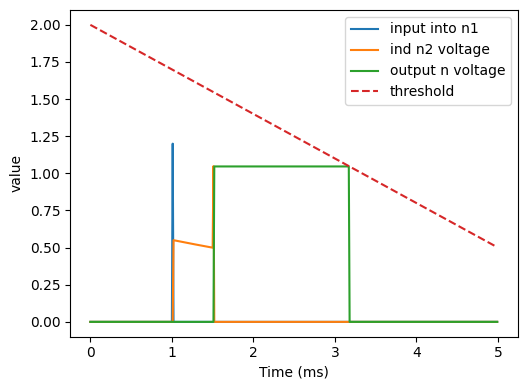

[0]


In [ ]:
# # example of decarying threshold: 
# # going to just edit with layer 1


# from brian2 import *
# import numpy as np
# import logging, warnings

# start_scope()

# defaultclock.dt = 0.01*ms  

# #prefs.codegen.target = 'cython'
# set_device('runtime')
# warnings.filterwarnings('ignore', category=RuntimeWarning)  # check error later
# np.seterr(over='ignore', under='ignore')
# logging.getLogger('brian2').setLevel(logging.ERROR)

# decay_rate = 5*ms

# def run_Ymir(inputs, y, taus1):

#     x = len(inputs)
#     xy_ind = x*y
 

#     if len(taus1) != xy_ind:
#         print("not the right size for taus1 buddy")
#         raise ValueError(f"Length of taus1 wrong .")

#     input_neurons = NeuronGroup(x,'''
#     dv/dt = -v/ decay_rate : volt                 
#         ''',
#     threshold='v > 1.0 * volt',
#     reset='v = 0 * volt',
#     method='exact')
#     input_neurons.v = 0 * volt

#     indices_input = []
#     for i in range(0, x):
#         indices_input.append(i)

#     stim_input = SpikeGeneratorGroup(x, indices=indices_input, times= inputs * ms)

#     syn_input = Synapses(stim_input, input_neurons[0:x], '''
#     ''', on_pre='''
#         v += 1.2 * volt
#     ''')
#     syn_input.connect(j='i') 

#     ind_input_neurons = NeuronGroup(xy_ind,
#     '''dv/dt = -v/ decay_rate : volt 
         
#         ''',
#     threshold='v > 1.0 * volt',
#     reset='v = 0 * volt',
#     method='exact')
#     ind_input_neurons.v = 0 * volt

#     input_range = []
#     for i in range(0, x):
#         for j in range(0, y):
#             input_range.append(i)


#     ind_input = Synapses(input_neurons[0:x], ind_input_neurons[0:xy_ind], '''
#     ''', on_pre='''
#         v += 0.55 * volt
#     ''')
#     ind_input.connect(i=input_range, j=[k for k in range(0, xy_ind)]) # look into what j is later


#     stim_tau_hidden = SpikeGeneratorGroup(xy_ind, indices=[k for k in range(0, xy_ind)], times = taus1 * ms)

#     syn_tau_hidden = Synapses(stim_tau_hidden, ind_input_neurons[0:xy_ind], '''
#     ''', on_pre='''
#         v += 0.55 * volt
#     ''')
#     syn_tau_hidden.connect(j='i')

#     theta_decay_k = 6.0

#     hidden_neurons = NeuronGroup(
#     y,
#     '''
#     v : volt
#     dVth/dt = -k : volt
#     k : volt/second
#     locked : integer
#     ''',
#     threshold='(v > Vth) and (locked == 0)',
#     reset='''
#     v = 0*volt
#     locked = 1
#     ''',
#     method='euler'  # Euler is required to integrateso we can integrate the decay
#     )

#     hidden_neurons.v = 0*volt
#     hidden_neurons.Vth = 2*volt
#     hidden_neurons.k = 300 *volt/second  # decay rate
#     hidden_neurons.locked = 0



#     output_range = []
#     for i in range(0, x):
#         for j in range(0, y):
#             output_range.append(j)

#     syn_ind_hidden = Synapses(ind_input_neurons[0:xy_ind], hidden_neurons[0:y], '''
#     ''', on_pre='''
#         v_post = v_pre
#     ''')
#  #v += 1.2 * volt
#     syn_ind_hidden.connect(i=[k for k in range(0, xy_ind)], j=output_range)



#     mon = StateMonitor(input_neurons, 'v', record=True, dt=0.01*ms)
#     M1 = StateMonitor(ind_input_neurons, 'v', record=True, dt=0.01*ms)
#     M2 = StateMonitor(hidden_neurons, ['v', 'Vth'], record=True, dt=0.01*ms)


#     spikemon = SpikeMonitor(input_neurons)
#     spikemon_1 = SpikeMonitor(ind_input_neurons)
#     spikemon_2 = SpikeMonitor(hidden_neurons)


#     run(5*ms)

#     plt.figure(figsize=(10,4))

#     plt.subplot(1,2,1)
#     plt.plot(mon.t/ms, mon.v[0], label='input into n1')
#     plt.plot(M1.t/ms, M1.v[0], label='ind n2 voltage')
#     plt.plot(M2.t/ms, M2.v[0], label='output n voltage')
#     plt.plot(M2.t/ms, M2.Vth[0], '--', label='threshold')
#     #plt.plot(M_mid.t/ms, M_mid.theta[0], '--', label='theta (middle)')
#     #plt.plot(M_out.t/ms, M_out.v[0], label='v (output)')
#     plt.xlabel('Time (ms)')
#     plt.ylabel('value')
#     plt.legend()

#     #plt.subplot(1,2,2)
#     #plt.plot(spm_mid.t/ms, spm_mid.i, 'o', label='middle spikes')
#     #plt.plot(spm_out.t/ms, spm_out.i + 1, 'o', label='output spikes')  # offset for display
#     #plt.yticks([0, 1], ['middle', 'output'])
#     #plt.xlabel('Time (ms)')
#     #plt.legend()

#     plt.tight_layout()
#     plt.show()


#     results = []
#     results.append(spikemon.spike_trains())
#     results.append(spikemon_1.spike_trains())
#     results.append(spikemon_2.spike_trains())

    

#     return results   # check the dictionalry apect of this as the odder might be changing so harder wirinign i-j such relationship

# # funcition for training taus
# def see_system_run():
#     raw_results = run_Ymir(inputs, y, taus1)

#     recorded_spikes = [
#         {neuron_idx: (spike_times / ms).tolist()  # convert to float ms
#         for neuron_idx, spike_times in group.items()}
#         for group in raw_results
#     ]

#     print("Recorded spikes:", recorded_spikes)

#     for i in range(len(recorded_spikes)):
#         print(f"Group {i} spikes:")
#         for neuron_idx, spike_times in recorded_spikes[i].items():
#             print(f"  Neuron {neuron_idx}: {spike_times}")
#         print()

# def tau_shifer(spike, tau, i, strength, closer=True):
#     global h_neurons_sumed_movements
#     # i is equal to what syn we are on 0 and 2 are n0 and 1 & 3 --> n1
#     delta = spike - tau
#     j = int(i > 1)

#     if closer:
#         # Original behavior: bigger delta → bigger step toward spike
#         step = delta * strength
#         if tau + step < 0:
#             h_neurons_sumed_movements[j] += 0.02
#             return 0.02
#         h_neurons_sumed_movements[j] += step
#         return tau + step
#     else:
#         # Inverse scaling: bigger delta → smaller step
#         if delta == 0:
#             h_neurons_sumed_movements[j] += 0.02
#             return tau + 0.02  # struck will always fire if - is in range? - make sure 0 is always out of range for possilbe inputs? 
#         step = (strength / abs(delta)) * delta  # sign from delta
#         if tau - step < 0:
#             h_neurons_sumed_movements[j] += 0.02
#             return 0.02
#         h_neurons_sumed_movements[j] -= step
#         return tau - step
        
# def directions(output_spikes, desired):
#      # just firinng for a single spike or not change change later
#     mods = [-1] * len(desired)  # assuming we want to modify all neurons
    
#     for i in range(len(desired)): 
#         if desired[i] == True:    # if we wanted a spike
#             if output_spikes[i] == []: # if no spike saw
#                 mods[i] = 2 
#             else:                   # if spike saw
#                 mods[i] = 0
#         else:
#             if output_spikes[i] == []: # if we didnt want a spike and it didnt spike
#                 mods[i] = 3
#             else:   # if we didnt want it to spike but it did
#                 mods[i] = 1
#     return mods     

# def train_taus_last_layer(inputs, taus1, strength, desired):

#     # run it and gets data with current values
#     raw_results = run_Ymir(inputs, y, taus1)

#     recorded_spikes = [
#         {neuron_idx: (spike_times / ms).tolist()  # convert to float ms
#         for neuron_idx, spike_times in group.items()}
#         for group in raw_results
#     ]
#      # here we have the data of all the spikes and taus and desired we send into to get new taus
    
#     d = directions(recorded_spikes[2], desired)  # get the directions for the taus

#     # basied on direction get proper assocaltion for each direction and strength for updating and send each though tau shifter
#     move = False
#     count = 0
#     index = 0
#     '''for i in range((len(taus2))):
#         # if spike as well
#             #if i % 2 == 0: # even index taus        # will need to change to extend to multi later
#         if d[index] % 2 == 0:  # 0 and 2 here
#             move = True
#         else:
#             move = False
#         if recorded_spikes[2][count] != []:  # if we saw a spike
 
#             new_tau = tau_shifer(recorded_spikes[2][count][0], taus2[i], i, strength, closer=move)
#             #print("new tay and old tau: ", new_tau, taus2[i])
#             taus2[i] = new_tau
    
#         else: 
#             #new_tau = tau_shifer(0, taus2[i], strength, closer=move)  # if no spike saw then just use 0
#             print("condition of change on condition of hidden not having spike ")# DID YOU EVER GOT HEREEEE")
#             #print("no spike saw so no update?" )#new tay and old tau: ", new_tau, taus2[i])
#             #taus2[i] = new_tau

#         if (i+1) % 2 == 0:
#             count += 1
#         if index == 0:
#             index += 1
#         elif index == 1:
#             index = 0
#     '''

#     return #recorded_spikes[3]  # return the last layer spikes for now

    


# inputs = [1.0]
# y = 1
# z = 1

# h_neurons_sumed_movements = [0] * y 

# taus1 = [1.5] 
# #taus2 = [1.2] 

# # run_Ymir(inputs, y, z, taus1, taus2)

# train_taus_last_layer(inputs, taus1, .1, [True])

# print(h_neurons_sumed_movements)




In [2]:
# example 2 varying inputs to train specifics 1.0 goes to T/F and 1.5 goes to F/T 

y = 2
z = 2
taus1 = [1.1, 1.1] 
taus2 = [1.2, 1.3, 1.35, 1.4] 

h_neurons_sumed_movements = [0] * y 

# see_system_run()

for i in range(3):
    train_taus_last_layer([1.0], taus1, taus2, .1, [True, False])
    train_taus_last_layer([1.5], taus1, taus2, .1, [False, True])

# inputs = [1.0]
# see_system_run() # should only see first one spike
# inputs = [1.5]
# see_system_run()

print(h_neurons_sumed_movements) # can divide by x many run for averaged movement needed





[0.01355000000000003, -0.054200000000000026]


In [ ]:
# inputs = [1.0]
# y = 1
# z = 0

# h_neurons_sumed_movements = [0] * y 

# taus1 = [1.1] 
# taus2 = [1.2] 

# # run_Ymir(inputs, y, z, taus1, taus2)

# train_taus_last_layer(inputs, taus1, taus2, .1, [True])

# print(h_neurons_sumed_movements)

MagicError: The magic network contains a mix of objects that has been run before and new objects, Brian does not know whether you want to start a new simulation or continue an old one. Consider explicitly creating a Network object. Also note that you can find out which objects will be included in a magic network with the collect() function.

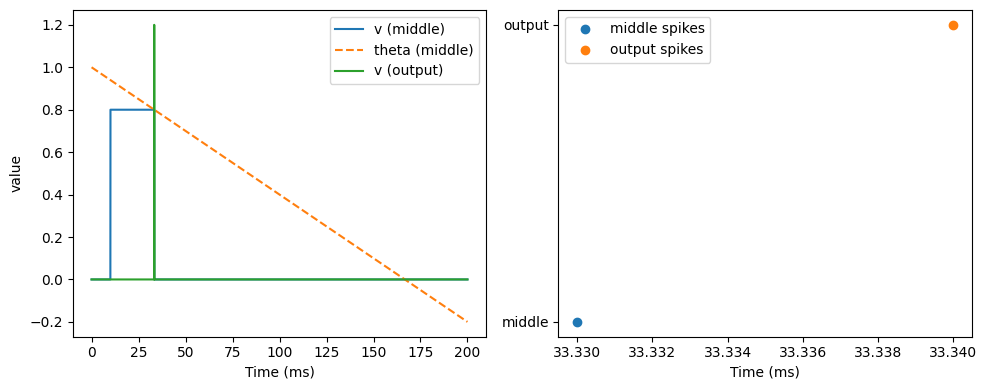

In [ ]:
# from brian2 import *

# start_scope()

# # Parameters
# spike_amp = 0.8        # input spike amplitude to middle neuron
# theta0 = 1.0           # middle initial threshold
# theta_decay_k = 6.0    # threshold decay rate (units: 1/s via *Hz)
# spike_time = 10*ms     # when the input spike arrives
# duration = 200*ms
# w_mid_to_out = 1.2     # weight from middle -> output
# Vth_out = 0.5          # output threshold

# # ---- Middle neuron (index 0) ----
# eqs_middle = '''
# v : 1
# dtheta/dt = -k*Hz : 1
# k : 1
# has_spiked : integer
# '''
# middle = NeuronGroup(1, model=eqs_middle,
#                      threshold='(v > theta) and (has_spiked == 0)',
#                      reset='v = 0; has_spiked = 1',
#                      method='euler')
# middle.v = 0
# middle.theta = theta0
# middle.k = theta_decay_k
# middle.has_spiked = 0

# # ---- Output neuron (index 0 in its group) ----
# eqs_out = '''
# v : 1
# Vth : 1
# locked : integer
# '''
# output = NeuronGroup(1, model=eqs_out,
#                      threshold='(v > Vth) and (locked == 0)',
#                      reset='v = 0; locked = 1',
#                      method='euler')
# output.v = 0
# output.Vth = Vth_out
# output.locked = 0

# # ---- Input spike -> middle ----
# inp = SpikeGeneratorGroup(1, indices=[0], times=[spike_time])
# Sin = Synapses(inp, middle, model='w:1', on_pre='v_post += w')
# Sin.connect(i=0, j=0)
# Sin.w = spike_amp

# # ---- Middle -> output synapse:
# # add to output v but only if output not locked (1 - locked_post)
# # ----
# S = Synapses(middle, output, model='w:1',
#              on_pre='v_post += w * (1 - locked_post)')
# S.connect(i=0, j=0)
# S.w = w_mid_to_out

# # ---- Monitors ----
# M_mid = StateMonitor(middle, ['v', 'theta', 'has_spiked'], record=True)
# M_out = StateMonitor(output, ['v', 'locked'], record=True)
# spm_mid = SpikeMonitor(middle)
# spm_out = SpikeMonitor(output)

# # ---- Run ----
# run(duration)

# # ---- Plot ----
# import matplotlib.pyplot as plt
# plt.figure(figsize=(10,4))

# plt.subplot(1,2,1)
# plt.plot(M_mid.t/ms, M_mid.v[0], label='v (middle)')
# plt.plot(M_mid.t/ms, M_mid.theta[0], '--', label='theta (middle)')
# plt.plot(M_out.t/ms, M_out.v[0], label='v (output)')
# plt.xlabel('Time (ms)')
# plt.ylabel('value')
# plt.legend()

# plt.subplot(1,2,2)
# plt.plot(spm_mid.t/ms, spm_mid.i, 'o', label='middle spikes')
# plt.plot(spm_out.t/ms, spm_out.i + 1, 'o', label='output spikes')  # offset for display
# plt.yticks([0, 1], ['middle', 'output'])
# plt.xlabel('Time (ms)')
# plt.legend()

# plt.tight_layout()
# plt.show()


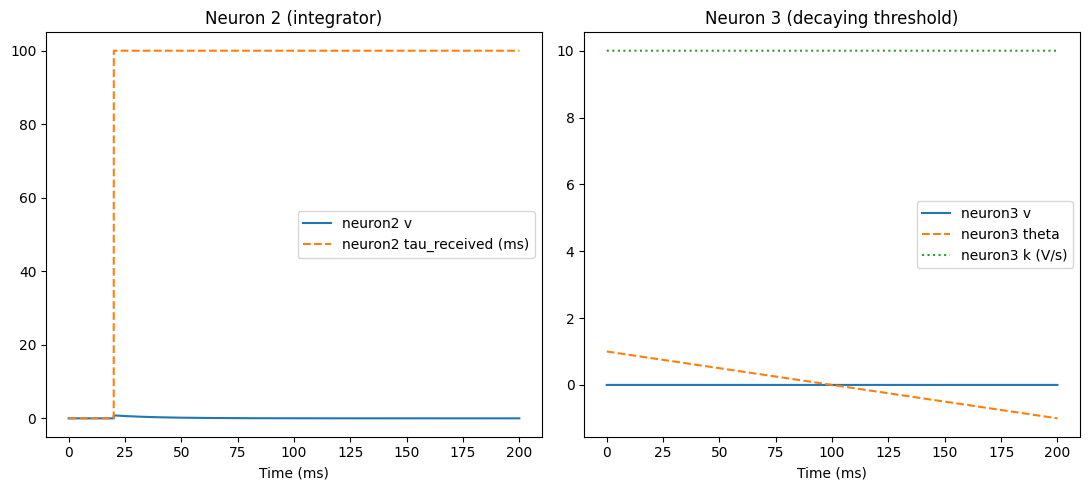

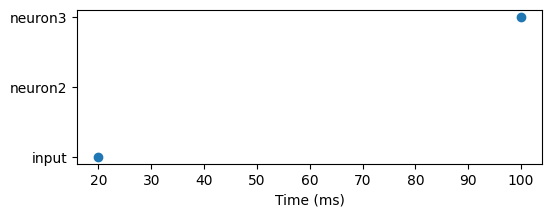

In [ ]:
# from brian2 import *

# start_scope()

# # -------------------------
# # Parameters (tweak these)
# # -------------------------
# spike_time = 20*ms        # time of input spike
# w_input = 0.8 * volt      # amplitude added to neuron2.v on input

# # neuron2 (middle) membrane time constant (voltage decay)
# tau_v2 = 20 * ms          # time constant for v decay (dv/dt = -v/tau_v2)
# Vth2 = 1.0 * volt         # threshold for neuron2
# refractory2 = 2*ms

# # neuron3 (final) threshold parameters
# theta0 = 1.0 * volt       # initial threshold for neuron3
# theta_min = 0.0 * volt    # minimum threshold (optional)
# # tau for theta decay will be provided per-spike and forwarded by neuron2

# # a sample tau provided by the input spike (the "tau you give me")
# tau_input = 100*ms

# duration = 200*ms

# # -------------------------
# # Input spike generator
# # -------------------------
# inp = SpikeGeneratorGroup(1, indices=[0], times=[spike_time])

# # -------------------------
# # neuron2: leaky integrator that stores a received tau
# # IMPORTANT: do NOT declare `v : volt` here because dv/dt defines v.
# # -------------------------
# eqs_mid = '''
# dv/dt = -v / tau_v : volt     
# tau_v : second                
# tau_received : second         
# '''
# mid = NeuronGroup(1, model=eqs_mid,
#                   threshold='v > Vth2',
#                   reset='v = 0*volt',
#                   refractory=refractory2,
#                   method='euler')
# mid.v = 0*volt
# mid.tau_v = tau_v2
# mid.tau_received = 0*ms

# # -------------------------
# # neuron3: final neuron with decaying threshold
# # - note: here v has no differential equation so we declare it explicitly
# # - theta is defined by the differential equation (do NOT also declare 'theta : volt')
# # -------------------------
# eqs_final = '''
# v : volt
# dtheta/dt = -k : volt
# k : volt/second
# locked : integer
# '''
# final = NeuronGroup(1, model=eqs_final,
#                     threshold='(v > theta) and (locked == 0)',
#                     reset='v = 0*volt; locked = 1',
#                     method='euler')
# final.v = 0*volt
# final.theta = theta0
# final.k = (theta0 - theta_min) / (100*ms)  # default value; will be overwritten on forwarding
# final.locked = 0

# # -------------------------
# # Input -> neuron2 synapse:
# # - add w_input to neuron2.v
# # - write the tau into neuron2.tau_received
# # -------------------------
# sin = Synapses(inp, mid, model='''
#                w : volt
#                tau_in : second''',
#                on_pre='''v_post += w
#                tau_received_post = tau_in''')
# sin.connect(i=0, j=0)
# sin.w = w_input
# sin.tau_in = tau_input

# # -------------------------
# # neuron2 -> neuron3 synapse:
# # - forward instantaneous v_pre to final.v
# # - set final.k according to tau_received_pre:
# #     k_post = (theta0 - theta_min) / tau_received_pre
# # - (1 - locked_post) prevents updating final if it's locked
# # NOTE: this assumes tau_received_pre > 0. If zero possible, add a guard.
# # -------------------------
# S = Synapses(mid, final, # set final.k based on the tau that neuron2 received earlier # transfer the instantaneous v_pre to final (no-op if final locked)
#              on_pre='''
# k_post = (theta0 - theta_min) / tau_received_pre
# v_post += v_pre * (1 - locked_post)
# ''')
# S.connect(i=0, j=0)

# # -------------------------
# # Monitors
# # -------------------------
# M_mid = StateMonitor(mid, ['v', 'tau_received'], record=True)
# M_final = StateMonitor(final, ['v', 'theta', 'k', 'locked'], record=True)
# sp_mid = SpikeMonitor(mid)
# sp_final = SpikeMonitor(final)

# # -------------------------
# # Run
# # -------------------------
# run(duration)

# # -------------------------
# # Plots
# # -------------------------
# import matplotlib.pyplot as plt
# plt.figure(figsize=(11,5))

# plt.subplot(1,2,1)
# plt.plot(M_mid.t/ms, M_mid.v[0]/volt, label='neuron2 v')
# plt.plot(M_mid.t/ms, M_mid.tau_received[0]/ms, '--', label='neuron2 tau_received (ms)')
# plt.xlabel('Time (ms)')
# plt.legend()
# plt.title('Neuron 2 (integrator)')

# plt.subplot(1,2,2)
# plt.plot(M_final.t/ms, M_final.v[0]/volt, label='neuron3 v')
# plt.plot(M_final.t/ms, M_final.theta[0]/volt, '--', label='neuron3 theta')
# plt.plot(M_final.t/ms, M_final.k[0]/(volt/second), ':', label='neuron3 k (V/s)')
# plt.xlabel('Time (ms)')
# plt.legend()
# plt.title('Neuron 3 (decaying threshold)')

# plt.tight_layout()
# plt.show()

# # Raster
# plt.figure(figsize=(6,2))
# ys = []
# ts = []
# ts.append(spike_time/ms); ys.append(0)
# for t in sp_mid.t:
#     ts.append(t/ms); ys.append(1)
# for t in sp_final.t:
#     ts.append(t/ms); ys.append(2)
# plt.plot(ts, ys, 'o')
# plt.yticks([0,1,2], ['input','neuron2','neuron3'])
# plt.xlabel('Time (ms)')
# plt.show()
